# Building makemore - MLP

> This lecture note will mostly be following the https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf paper

In [75]:
import numpy
import torch
import torch.nn.functional as F
from rich import print
from rich import pretty
import matplotlib.pyplot as plot
%matplotlib inline

In [76]:
pretty.install()

## Read in all the words

In [77]:
words = open('../data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [78]:
len(words)

32033

## Build the vocabulary of characters and mapping to/from integers

In [79]:
chars = sorted(list(set(''.join(words))))

In [80]:
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0

In [81]:
itos = {i:s for s, i in stoi.items()}

In [82]:
itos

{
    1: 'a',
    2: 'b',
    3: 'c',
    4: 'd',
    5: 'e',
    6: 'f',
    7: 'g',
    8: 'h',
    9: 'i',
    10: 'j',
    11: 'k',
    12: 'l',
    13: 'm',
    14: 'n',
    15: 'o',
    16: 'p',
    17: 'q',
    18: 'r',
    19: 's',
    20: 't',
    21: 'u',
    22: 'v',
    23: 'w',
    24: 'x',
    25: 'y',
    26: 'z',
    0: '.'
}

## Build the training dataset

In [83]:
block_size = 3

What is `block_size`?
> context length: how many characters do we take to predict the next one?

In [84]:
def generate_training_set(words, block_size, print_disabled=False):
    X, Y = [], []
    for w in words:
        if print_disabled: print(w)
        
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            if print_disabled: print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

### Generating training set for block size of 2

In [85]:
X, Y = generate_training_set(words[:2], 2, True)

emma

.. ---> e

.e ---> m

em ---> m

mm ---> a

ma ---> .

olivia

.. ---> o

.o ---> l

ol ---> i

li ---> v

iv ---> i

vi ---> a

ia ---> .

### Generating training set for block size of 5

In [86]:
X, Y = generate_training_set(words[:2], 5, True)

emma

..... ---> e

....e ---> m

...em ---> m

..emm ---> a

.emma ---> .

olivia

..... ---> o

....o ---> l

...ol ---> i

..oli ---> v

.oliv ---> i

olivi ---> a

livia ---> .

### Generate training set for block size of 3 
> as mentioned in the above paper

In [87]:
X, Y = generate_training_set(words[:2], 3)

In [88]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([12, 3]), torch.int64, torch.Size([12]), torch.int64)

## Embedding Lookup Table

In [89]:
C = torch.randn((27, 2))

In [90]:
C.dtype

torch.float32

In [91]:
C

tensor([[-1.7749,  0.4311],
        [ 1.0820, -0.9515],
        [ 0.0319,  0.1056],
        [ 0.7130, -0.1777],
        [-0.9202,  0.8703],
        [ 1.8403, -0.2517],
        [ 1.9564,  0.0913],
        [-1.5335,  2.2349],
        [-0.2757, -0.4090],
        [-0.2682, -0.7152],
        [-0.6230,  0.1392],
        [-0.5747, -1.1926],
        [ 1.3426, -0.2226],
        [-1.0854, -0.0892],
        [-0.9341, -0.7644],
        [ 2.3032, -0.5847],
        [-0.8420, -1.0431],
        [-0.6343, -0.9925],
        [-0.8765, -0.5907],
        [ 0.4062,  1.9024],
        [ 0.3679,  0.7414],
        [-0.4929,  1.2513],
        [ 0.8837,  0.7330],
        [-0.8532,  0.9143],
        [ 0.9330, -2.8293],
        [-0.6336,  0.0916],
        [-0.8129,  0.1851]])

### Indexing into the embedding

#### 1. Index with a number

In [92]:
C[5]

tensor([ 1.8403, -0.2517])

#### 2. Multiplying with one-hot encoding

In [93]:
one_hot_vec = F.one_hot(torch.tensor(5), num_classes=27).float()

Converted the above one into float so that it can be multiplied with `C`, which is a float

In [94]:
one_hot_vec.shape

torch.Size([27])

In [95]:
one_hot_vec @ C

tensor([ 1.8403, -0.2517])

As we can see the result is same as indexing with a number

In [96]:
torch.equal(one_hot_vec @ C, C[5])

True

##### Lets explore indexing 

In [97]:
C[torch.tensor([5, 6, 7, 7, 7, 7, 7])]

tensor([[ 1.8403, -0.2517],
        [ 1.9564,  0.0913],
        [-1.5335,  2.2349],
        [-1.5335,  2.2349],
        [-1.5335,  2.2349],
        [-1.5335,  2.2349],
        [-1.5335,  2.2349]])

In [98]:
C[X]

tensor([[[-1.7749,  0.4311],
         [-1.7749,  0.4311],
         [-1.7749,  0.4311]],

        [[-1.7749,  0.4311],
         [-1.7749,  0.4311],
         [ 1.8403, -0.2517]],

        [[-1.7749,  0.4311],
         [ 1.8403, -0.2517],
         [-1.0854, -0.0892]],

        [[ 1.8403, -0.2517],
         [-1.0854, -0.0892],
         [-1.0854, -0.0892]],

        [[-1.0854, -0.0892],
         [-1.0854, -0.0892],
         [ 1.0820, -0.9515]],

        [[-1.7749,  0.4311],
         [-1.7749,  0.4311],
         [-1.7749,  0.4311]],

        [[-1.7749,  0.4311],
         [-1.7749,  0.4311],
         [ 2.3032, -0.5847]],

        [[-1.7749,  0.4311],
         [ 2.3032, -0.5847],
         [ 1.3426, -0.2226]],

        [[ 2.3032, -0.5847],
         [ 1.3426, -0.2226],
         [-0.2682, -0.7152]],

        [[ 1.3426, -0.2226],
         [-0.2682, -0.7152],
         [ 0.8837,  0.7330]],

        [[-0.2682, -0.7152],
         [ 0.8837,  0.7330],
         [-0.2682, -0.7152]],

        [[ 0.8837,  0.7330],
         [-0.2682, -0.7152],
         [ 1.0820, -0.9515]]])

In [99]:
C[X].shape

torch.Size([12, 3, 2])

In [100]:
X[11, 2]

tensor(1)

In [101]:
C[X][11, 2]

tensor([ 1.0820, -0.9515])

In [102]:
C[1]

tensor([ 1.0820, -0.9515])

In [103]:
torch.equal(C[X][11, 2], C[1])

True

## Hidden Layer

In [104]:
emb = C[X]
emb.shape

torch.Size([12, 3, 2])

In [105]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [106]:
W1.shape, b1.shape

(torch.Size([6, 100]), torch.Size([100]))

We have to flatten the last two dimensions of `emb` so that it can be multiplied with `W1`

In [107]:
emb[:, 0, :].shape

torch.Size([12, 2])

### `torch.cat` and `torch.bind`

In [108]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([12, 6])

In [109]:
len(torch.unbind(emb, 1))

3

In [110]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([12, 6])

The above one is insufficient and creates memory

### torch internal: storage, views

In [111]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [112]:
a.shape

torch.Size([18])

In [113]:
a.view(2, 9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [114]:
a.view(9, 2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [115]:
a.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [116]:
a.storage()

0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [117]:
emb.shape

torch.Size([12, 3, 2])

In [118]:
emb.view(12, 6)

tensor([[-1.7749,  0.4311, -1.7749,  0.4311, -1.7749,  0.4311],
        [-1.7749,  0.4311, -1.7749,  0.4311,  1.8403, -0.2517],
        [-1.7749,  0.4311,  1.8403, -0.2517, -1.0854, -0.0892],
        [ 1.8403, -0.2517, -1.0854, -0.0892, -1.0854, -0.0892],
        [-1.0854, -0.0892, -1.0854, -0.0892,  1.0820, -0.9515],
        [-1.7749,  0.4311, -1.7749,  0.4311, -1.7749,  0.4311],
        [-1.7749,  0.4311, -1.7749,  0.4311,  2.3032, -0.5847],
        [-1.7749,  0.4311,  2.3032, -0.5847,  1.3426, -0.2226],
        [ 2.3032, -0.5847,  1.3426, -0.2226, -0.2682, -0.7152],
        [ 1.3426, -0.2226, -0.2682, -0.7152,  0.8837,  0.7330],
        [-0.2682, -0.7152,  0.8837,  0.7330, -0.2682, -0.7152],
        [ 0.8837,  0.7330, -0.2682, -0.7152,  1.0820, -0.9515]])

In [119]:
torch.equal(emb.view(12, 6), torch.cat(torch.unbind(emb, 1), 1))

True

#### Now lets multiply `emb` and `W1`

In [120]:
h = emb.view(12, 6) @ W1 + b1
h.shape

torch.Size([12, 100])

In [121]:
h = emb.view(emb.shape[0], 6) @ W1  + b1
h.shape

torch.Size([12, 100])

In [122]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [123]:
h

tensor([[-0.9971, -0.7555, -0.9956,  ..., -0.9987,  0.9074,  0.9996],
        [-0.9977, -0.3236, -0.9999,  ...,  0.1293, -0.0343,  0.1881],
        [-0.7903, -1.0000,  0.9941,  ..., -0.9909,  0.9837, -0.3976],
        ...,
        [ 0.7908,  0.9835, -0.0045,  ...,  0.9479,  0.9952, -0.8991],
        [ 0.4927, -0.9203,  0.6918,  ...,  0.9571,  0.5090,  0.9262],
        [ 0.8617,  0.9699, -0.3373,  ...,  0.9915,  0.8434, -0.9987]])

In [124]:
h.shape

torch.Size([12, 100])

#### Deconstruct the addition of `emb.view(-1, 6) @ W1` and `b1` : Broadcasting

In [125]:
(emb.view(-1, 6) @ W1).shape

torch.Size([12, 100])

In [126]:
b1.shape

torch.Size([100])

Broadcasting

- 12 by 100

- 1   by 100

Rowwise addition of `b1` to `(emb.view(-1, 6) @ W1)`

## Output Layer

In [127]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [128]:
logits = h @ W2 + b2

In [129]:
logits.shape

torch.Size([12, 27])

In [130]:
counts = logits.exp()

In [131]:
prob = counts/counts.sum(1, keepdims=True)

In [132]:
prob.shape

torch.Size([12, 27])

In [133]:
prob[0].sum()

tensor(1.)

In [134]:
torch.arange(12)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [135]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0])

In [136]:
prob[torch.arange(12), Y]

tensor([8.0526e-02, 3.8984e-03, 7.0498e-11, 9.7839e-10, 1.8278e-09, 2.0743e-07,
        2.8251e-10, 4.8393e-04, 4.0496e-07, 3.4973e-10, 3.5017e-10, 1.3807e-01])

In [137]:
loss = -prob[torch.arange(12), Y].log().mean()
loss

tensor(14.7969)

## Summary of the Full Network

In [138]:
X.shape, Y.shape

(torch.Size([12, 3]), torch.Size([12]))

In [139]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [140]:
sum(p.nelement() for p in parameters)

3481

In [141]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
counts = logits.exp()
prob = counts/counts.sum(1, keepdims=True)
loss = -prob[torch.arange(12), Y].log().mean()
loss

tensor(19.1366)

## Introducting F.cross_entropy and why?

In [142]:
F.cross_entropy(logits, Y)

tensor(19.1366)

### why?

1. Pytorch does not create intermediate tensors for the following code
<code>
counts = logits.exp()
prob = counts/counts.sum(1, keepdims=True)
loss = -prob[torch.arange(12), Y].log().mean()
</code>
Instead it clusters up all the above operation and it efficiently computes 


2. Backward prop is efficient. Simple to implement


3. It can numerically well behaved

In [143]:
logits = torch.tensor([-2, -3, 0, 5])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([9.0466e-04, 3.3281e-04, 6.6846e-03, 9.9208e-01])

In [144]:
logits = torch.tensor([-100, -3, 0, 100])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0., 0., 0., nan])

In [145]:
counts

tensor([3.7835e-44, 4.9787e-02, 1.0000e+00,        inf])

As we can see the negative numbers are ok, but positive numbers can overflow the exp

So pytorch internally offset the logits with maximum number

In [146]:
logits = torch.tensor([-100, -3, 0, 100]) - 100
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])

so better to call `F.cross_entropy(logits, Y)`

## Implementing the Training Loop, overfitting one batch

In [150]:
for p in parameters: p.requires_grad = True 

In [151]:
for _ in range(10):
    # forward pass
    emb = C[X] # (12, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 # (12, 27)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad= None
    loss.backward()
    
    for p in parameters:
        p.data += -0.1 * p.grad

19.136564254760742

13.381081581115723

9.38259220123291

6.92555570602417

4.83230447769165

3.4374144077301025

2.392893075942993

1.488807201385498

0.9096290469169617

0.6129968762397766

In [152]:
logits.max(1)

torch.return_types.max(
values=tensor([ 9.7356, 13.5384, 12.3221, 12.4568, 14.5028,  9.7356, 10.2301, 14.6009,
         5.6935, 15.5763,  5.5577, 18.4309], grad_fn=<MaxBackward0>),
indices=tensor([15, 13, 13,  1,  0, 15, 12,  9, 12,  9,  7,  0]))

In [153]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0])

## Training on a full dataset

In [217]:
X, Y = generate_training_set(words, 3)

In [218]:
X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64, torch.int64)

In [221]:
def train(epochs, X, Y):
    g = torch.Generator().manual_seed(42)
    C = torch.randn((27, 2), generator=g)
    W1 = torch.randn((6, 100), generator=g)
    b1 = torch.randn(100, generator=g)
    W2 = torch.randn((100, 27), generator=g)
    b2 = torch.randn(27, generator=g)
    parameters = [C, W1, b1, W2, b2]
    
    for p in parameters: p.requires_grad = True 
        
    for _ in range(epochs):
        # forward pass
        emb = C[X] # (12, 3, 2)
        h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (-1, 100)
        logits = h @ W2 + b2 # (-1, 27)
        loss = F.cross_entropy(logits, Y)
        print(loss.item())
        # backward pass
        for p in parameters:
            p.grad= None
        loss.backward()

        for p in parameters:
            p.data += -0.1 * p.grad  
    return parameters

In [222]:
C[X].shape

torch.Size([228146, 3, 2])

In [223]:
params = train(10, X, Y)

16.72646713256836

14.942935943603516

13.863016128540039

13.003832817077637

12.292207717895508

11.732644081115723

11.270576477050781

10.859724044799805

10.47972583770752

10.136446952819824

### Generate minibatches

In [225]:
torch.randint(0, 5, (32, ))

tensor([3, 3, 1, 3, 4, 2, 3, 4, 3, 0, 1, 4, 0, 1, 2, 4, 2, 2, 1, 3, 2, 4, 3, 1,
        0, 1, 0, 4, 0, 1, 3, 2])

In [226]:
torch.randint(0, X.shape[0], (32,))

tensor([156825, 142682,    580,  31795, 130508,  72844, 102731,  12378,  81761,
         96245, 213884,  13716,  17611,  76130,  99948, 218690, 220172,  98212,
        160162,  87804, 193862,  87769, 111105, 150944, 208641, 192086, 220956,
        160695,  96617,  30760, 164713,  43596])

In [227]:
ix = torch.randint(0, X.shape[0], (32,))

In [228]:
ix

tensor([ 59816,  56947, 213921, 214083, 204098,  63636,  26114, 158714,  42227,
        205965, 173581,  33894,  39252,  25401, 169901,  63827,  51776, 163530,
        183663, 203664,   6202,  82817,  86832, 143352,  70925, 197083, 119422,
         16485,  95859,  71663, 220297, 171481])

### Train on minibatches

In [390]:
def train(epochs, X, Y, lr=0.1, parameters=[], enable_print=True):
    if not parameters:
        g = torch.Generator().manual_seed(42)
        C = torch.randn((27, 2), generator=g)
        W1 = torch.randn((6, 100), generator=g)
        b1 = torch.randn(100, generator=g)
        W2 = torch.randn((100, 27), generator=g)
        b2 = torch.randn(27, generator=g)
        parameters = [C, W1, b1, W2, b2]
    else:
        C, W1, b1, W2, b2 = parameters
    
    for p in parameters: p.requires_grad = True 
        
    for _ in range(epochs):
        # forward pass
        ix = torch.randint(0, X.shape[0], (32, )) # taking minibatches of 32 size
        
        emb = C[X[ix]] # (12, 3, 2)
        h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (-1, 100)
        logits = h @ W2 + b2 # (-1, 27)
        loss = F.cross_entropy(logits, Y[ix])
        if enable_print: print(loss.item())
        # backward pass
        for p in parameters:
            p.grad= None
        loss.backward()

        for p in parameters:
            p.data += -lr * p.grad  
    return parameters, loss.item()

In [391]:
_, _ = train(10, X, Y)

13.637133598327637

16.32086944580078

12.640043258666992

12.875073432922363

10.907100677490234

9.58460807800293

14.135109901428223

11.69826602935791

11.369922637939453

8.687410354614258

In [362]:
params, loss = train(1000, X, Y, enable_print=False)
loss

3.1308131217956543

We have to define a function for evaluating loss on the whole dataset

In [363]:
def evaluate_loss(params, X, Y):
    C = params[0]
    W1 = params[1]
    b1 = params[2]
    W2 = params[3]
    b2 = params[4]
    
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss

In [364]:
evaluate_loss(params, X, Y) 

tensor(2.6600, grad_fn=<NllLossBackward0>)

In [365]:
params, loss = train(2000, X, Y, enable_print=False)
loss

2.2790145874023438

In [366]:
evaluate_loss(params, X, Y)

tensor(2.5719, grad_fn=<NllLossBackward0>)

## Finding a good learning rate

In [367]:
params, loss = train(10, X, Y) # default one is 0.1

15.001378059387207

15.839015007019043

12.870087623596191

13.336407661437988

13.130197525024414

9.89980697631836

10.323299407958984

10.67185115814209

12.875905990600586

10.47635269165039

In [368]:
params, loss = train(100, X, Y, 0.001)

13.871994018554688

17.3082275390625

16.276138305664062

16.752342224121094

15.046689987182617

17.830995559692383

13.933544158935547

15.390519142150879

20.355342864990234

18.667400360107422

19.183155059814453

15.295604705810547

18.599441528320312

14.340692520141602

16.938528060913086

15.195046424865723

15.59225845336914

16.465070724487305

13.818251609802246

17.285816192626953

14.382073402404785

17.707130432128906

16.847166061401367

17.062536239624023

16.929607391357422

17.248180389404297

18.132713317871094

17.176586151123047

15.870104789733887

16.834692001342773

17.156105041503906

18.285049438476562

16.918445587158203

15.860414505004883

16.43604850769043

14.84459114074707

15.504717826843262

12.409363746643066

15.460453987121582

10.637042999267578

11.94433307647705

16.0494441986084

16.84019660949707

15.815882682800293

17.930086135864258

16.299571990966797

17.572729110717773

16.61911392211914

19.638303756713867

16.694002151489258

18.708654403686523

15.46377944946289

17.627099990844727

14.878548622131348

12.6272554397583

16.838193893432617

15.51134204864502

17.023344039916992

14.554750442504883

14.09605884552002

17.330459594726562

15.526243209838867

12.732669830322266

15.036983489990234

14.55704116821289

15.84503173828125

13.896175384521484

16.515533447265625

15.440160751342773

15.4408597946167

16.77860450744629

15.04053020477295

15.74921989440918

17.144479751586914

13.957348823547363

13.837481498718262

14.554952621459961

13.742769241333008

14.834546089172363

15.320348739624023

16.178157806396484

14.162126541137695

14.475885391235352

13.318647384643555

13.024133682250977

15.554403305053711

13.040825843811035

13.139906883239746

13.412982940673828

14.798907279968262

15.035326957702637

15.793319702148438

17.829914093017578

15.960289001464844

13.849530220031738

17.776826858520508

13.689745903015137

15.337897300720215

16.165637969970703

14.501823425292969

Decreasing quite slow

In [369]:
params, loss = train(100, X, Y, 0.01)

17.388996124267578

16.101173400878906

16.666446685791016

15.492295265197754

16.715621948242188

15.353219985961914

15.858105659484863

16.197956085205078

15.303179740905762

14.744205474853516

11.5447359085083

15.99161148071289

14.986102104187012

12.7628812789917

13.546692848205566

12.42037582397461

13.75033187866211

13.79194164276123

14.285455703735352

16.599069595336914

15.258740425109863

13.229242324829102

12.756084442138672

13.26573657989502

13.684460639953613

14.660768508911133

12.862054824829102

14.245278358459473

14.357146263122559

11.458410263061523

11.821966171264648

12.716381072998047

13.883289337158203

11.598077774047852

12.858833312988281

16.61380386352539

12.148862838745117

13.49193000793457

10.177278518676758

11.080439567565918

12.726655960083008

9.768646240234375

11.888307571411133

11.018081665039062

13.185544967651367

14.140128135681152

11.767255783081055

12.747078895568848

12.592257499694824

9.93731689453125

10.026472091674805

13.056517601013184

9.692485809326172

9.362987518310547

11.76485538482666

11.758992195129395

12.660326957702637

13.334312438964844

11.502509117126465

11.664857864379883

10.495447158813477

11.49854850769043

10.558960914611816

11.877485275268555

10.34423828125

10.363540649414062

13.834330558776855

10.269207000732422

13.019203186035156

14.055901527404785

9.997955322265625

9.853982925415039

11.03466510772705

11.878741264343262

8.89499568939209

11.89167594909668

10.343008041381836

9.399772644042969

11.056382179260254

11.517064094543457

11.327260971069336

10.147430419921875

9.157273292541504

9.812376976013184

12.261354446411133

8.727984428405762

10.006928443908691

10.772300720214844

7.499904632568359

11.808846473693848

7.942626953125

8.363311767578125

10.620269775390625

10.263338088989258

7.396081924438477

9.791055679321289

8.91272258758545

10.139595985412598

10.85566234588623

9.947019577026367

Lets find a learning rate where the loss explodes

In [370]:
params, loss = train(100, X, Y, 1)

14.720062255859375

14.016024589538574

11.949493408203125

11.672293663024902

11.131048202514648

10.565898895263672

10.519474983215332

8.213149070739746

14.262014389038086

13.070488929748535

11.08617115020752

7.237859725952148

12.290790557861328

10.112265586853027

10.839119911193848

11.57097053527832

10.31793212890625

14.791447639465332

11.841386795043945

9.125185012817383

7.992520809173584

9.219705581665039

9.96473217010498

7.7848920822143555

9.177976608276367

10.050331115722656

12.011404991149902

9.284531593322754

7.542640686035156

7.947935581207275

7.953253746032715

8.60932445526123

7.737423419952393

9.348020553588867

7.323532581329346

7.8619561195373535

6.691267013549805

7.467713832855225

6.9790825843811035

7.042400360107422

9.186759948730469

7.447154521942139

5.56380033493042

6.638556003570557

8.602607727050781

6.6956467628479

7.388535976409912

6.729799270629883

5.445770263671875

6.913175582885742

7.2759108543396

6.625068187713623

6.28564977645874

7.375860691070557

9.400803565979004

6.610013008117676

7.786231517791748

7.244671821594238

7.294036388397217

5.410831928253174

10.112194061279297

5.862048149108887

7.325849533081055

6.161684513092041

7.260412693023682

7.868552207946777

6.074491024017334

6.905088901519775

9.65137767791748

6.253317356109619

7.082781791687012

9.664789199829102

9.606345176696777

10.358965873718262

6.918944358825684

8.293649673461914

8.623725891113281

7.092445373535156

8.128931999206543

9.234175682067871

8.036138534545898

8.628165245056152

8.532071113586426

9.168761253356934

8.102287292480469

9.711007118225098

8.563117980957031

6.842767238616943

7.290187358856201

5.701862812042236

7.058323383331299

9.545360565185547

7.501101493835449

6.698598384857178

9.503926277160645

7.051410675048828

8.124223709106445

11.410436630249023

9.738862037658691

6.985301494598389

In [371]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022,
        0.0022, 0.0023, 0.0023, 0.0023, 0.0023, 0.0023, 0.0023, 0.0024, 0.0024,
        0.0024, 0.0024, 0.0024, 0.0024, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
        0.0025, 0.0026, 0.0026, 0.0026, 0.0026, 0.0026, 0.0027, 0.0027, 0.0027,
        0.0027, 0.0027, 0.0027, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0029,
        0.0029, 0.0029, 0.0029, 0.0029, 0.0030, 0.0030, 0.0030, 0.0030, 0.0030,
        0.0031, 0.0031, 0.0031, 0.0031, 0.0032, 0.0032, 0.0032, 0.0032, 0.0032,
        0.0033, 0.0033, 0.0033, 0.0033, 0.0034, 0.0034, 0.0034, 0.0034, 0.0034,
        0.0035, 0.0035, 0.0035, 0.0035, 0.0036, 0.0036, 0.0036, 0.0036, 0.0037,
        0.0037, 0.0037, 0.0037, 0.0038, 0.0038, 0.0038, 0.0039, 0.0039, 0.0039,
        0.0039, 0.0040, 0.0040, 0.0040, 0.0040, 0.0041, 0.0041, 0.0041, 0.0042,
        0.0042, 0.0042, 0.0042, 0.0043, 0.0043, 0.0043, 0.0044, 0.0044, 0.0044,
        0.0045, 0.0045, 0.0045, 0.0045, 0.0046, 0.0046, 0.0046, 0.0047, 0.0047,
        0.0047, 0.0048, 0.0048, 0.0048, 0.0049, 0.0049, 0.0049, 0.0050, 0.0050,
        0.0050, 0.0051, 0.0051, 0.0051, 0.0052, 0.0052, 0.0053, 0.0053, 0.0053,
        0.0054, 0.0054, 0.0054, 0.0055, 0.0055, 0.0056, 0.0056, 0.0056, 0.0057,
        0.0057, 0.0058, 0.0058, 0.0058, 0.0059, 0.0059, 0.0060, 0.0060, 0.0060,
        0.0061, 0.0061, 0.0062, 0.0062, 0.0062, 0.0063, 0.0063, 0.0064, 0.0064,
        0.0065, 0.0065, 0.0066, 0.0066, 0.0067, 0.0067, 0.0067, 0.0068, 0.0068,
        0.0069, 0.0069, 0.0070, 0.0070, 0.0071, 0.0071, 0.0072, 0.0072, 0.0073,
        0.0073, 0.0074, 0.0074, 0.0075, 0.0075, 0.0076, 0.0076, 0.0077, 0.0077,
        0.0078, 0.0079, 0.0079, 0.0080, 0.0080, 0.0081, 0.0081, 0.0082, 0.0082,
        0.0083, 0.0084, 0.0084, 0.0085, 0.0085, 0.0086, 0.0086, 0.0087, 0.0088,
        0.0088, 0.0089, 0.0090, 0.0090, 0.0091, 0.0091, 0.0092, 0.0093, 0.0093,
        0.0094, 0.0095, 0.0095, 0.0096, 0.0097, 0.0097, 0.0098, 0.0099, 0.0099,
        0.0100, 0.0101, 0.0101, 0.0102, 0.0103, 0.0104, 0.0104, 0.0105, 0.0106,
        0.0106, 0.0107, 0.0108, 0.0109, 0.0109, 0.0110, 0.0111, 0.0112, 0.0112,
        0.0113, 0.0114, 0.0115, 0.0116, 0.0116, 0.0117, 0.0118, 0.0119, 0.0120,
        0.0121, 0.0121, 0.0122, 0.0123, 0.0124, 0.0125, 0.0126, 0.0127, 0.0127,
        0.0128, 0.0129, 0.0130, 0.0131, 0.0132, 0.0133, 0.0134, 0.0135, 0.0136,
        0.0137, 0.0137, 0.0138, 0.0139, 0.0140, 0.0141, 0.0142, 0.0143, 0.0144,
        0.0145, 0.0146, 0.0147, 0.0148, 0.0149, 0.0150, 0.0151, 0.0152, 0.0154,
        0.0155, 0.0156, 0.0157, 0.0158, 0.0159, 0.0160, 0.0161, 0.0162, 0.0163,
        0.0165, 0.0166, 0.0167, 0.0168, 0.0169, 0.0170, 0.0171, 0.0173, 0.0174,
        0.0175, 0.0176, 0.0178, 0.0179, 0.0180, 0.0181, 0.0182, 0.0184, 0.0185,
        0.0186, 0.0188, 0.0189, 0.0190, 0.0192, 0.0193, 0.0194, 0.0196, 0.0197,
        0.0198, 0.0200, 0.0201, 0.0202, 0.0204, 0.0205, 0.0207, 0.0208, 0.0210,
        0.0211, 0.0212, 0.0214, 0.0215, 0.0217, 0.0218, 0.0220, 0.0221, 0.0223,


In [372]:
def track_lr(epochs, X, Y, lre, enable_print=True):
    g = torch.Generator().manual_seed(42)
    C = torch.randn((27, 2), generator=g)
    W1 = torch.randn((6, 100), generator=g)
    b1 = torch.randn(100, generator=g)
    W2 = torch.randn((100, 27), generator=g)
    b2 = torch.randn(27, generator=g)
    parameters = [C, W1, b1, W2, b2]
    
    lrs = 10**lre
    
    for p in parameters: p.requires_grad = True 

    lri = []
    lres = []
    lossi = []
    
    for i in range(epochs):
        # forward pass
        ix = torch.randint(0, X.shape[0], (32, )) # taking minibatches of 32 size
        
        emb = C[X[ix]] # (32, 3, 2)
        h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
        logits = h @ W2 + b2 # (32, 27)
        loss = F.cross_entropy(logits, Y[ix])
        if enable_print: print(loss.item())
        
        # backward pass
        for p in parameters:
            p.grad= None
        loss.backward()

        lr = lrs[i]
        
        for p in parameters:
            p.data += -lr * p.grad  
        
        # track stats
        lri.append(lr)
        lres.append(lre[i])
        lossi.append(loss.item())
        
    return lri, lres, lossi

In [373]:
lri, lres, lossi = track_lr(1000, X, Y, lre, enable_print=False)

[<matplotlib.lines.Line2D object at 0x7fc32a272e90>]

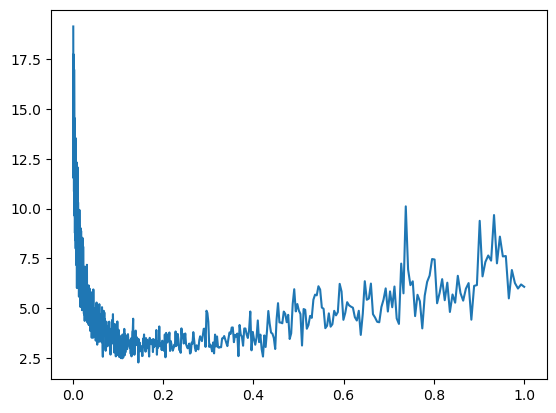

In [374]:
plot.plot(lri, lossi)

Lets plot the exponent of the learning rate

[<matplotlib.lines.Line2D object at 0x7fc2d86564d0>]

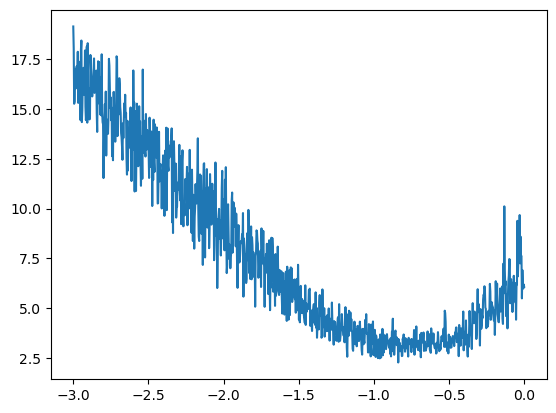

In [375]:
plot.plot(lres, lossi)

In [376]:
params, loss = train(10_000, X, Y, 0.1, enable_print=False)

In [377]:
loss

2.605109453201294

In [378]:
evaluate_loss(params, X, Y)

tensor(2.4452, grad_fn=<NllLossBackward0>)

### Learning rate decay

In [392]:
params, loss = train(10_000, X, Y, 0.1, enable_print=False)

In [393]:
evaluate_loss(params, X, Y)

tensor(2.4515, grad_fn=<NllLossBackward0>)

In [394]:
params, loss = train(10_000, X, Y, 0.01, params, enable_print=False)

In [395]:
evaluate_loss(params, X, Y)

tensor(2.3732, grad_fn=<NllLossBackward0>)

In [396]:
params, loss = train(10_000, X, Y, 0.001, params, enable_print=False)

In [397]:
evaluate_loss(params, X, Y)

tensor(2.3662, grad_fn=<NllLossBackward0>)